In [3]:
import os
import random
from pycocotools.coco import COCO
import shutil

In [7]:
coco_annotation_file = "C:/Users/chaha/Desktop/VisionExtract/annonations/instances_val2017.json"
coco_images_dir = "C:/Users/chaha/Desktop/VisionExtract/val2017"
output_dir = 'coco_subset'

In [8]:
os.makedirs(output_dir, exist_ok=True)
os.makedirs(f'{output_dir}/train/images', exist_ok=True)
os.makedirs(f'{output_dir}/val/images', exist_ok=True)
os.makedirs(f'{output_dir}/train/masks', exist_ok=True)
os.makedirs(f'{output_dir}/val/masks', exist_ok=True)

In [9]:
coco = COCO(coco_annotation_file)

loading annotations into memory...
Done (t=0.64s)
creating index...
index created!


In [10]:
all_img_ids = coco.getImgIds()
random.shuffle(all_img_ids)

In [12]:
subset_img_ids = all_img_ids

In [13]:
train_split = 0.8
num_train = int(len(subset_img_ids) * train_split)

train_ids = subset_img_ids[:num_train]
val_ids = subset_img_ids[num_train:]

In [14]:
def copy_images(img_ids, dest_folder):
    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        img_file = img_info['file_name']
        src_path = os.path.join(coco_images_dir, img_file)
        dst_path = os.path.join(dest_folder, img_file)
        shutil.copy(src_path, dst_path)

copy_images(train_ids, f'{output_dir}/train/images')
copy_images(val_ids, f'{output_dir}/val/images')

In [15]:
import numpy as np
from PIL import Image
from pycocotools import mask as maskUtils

def create_mask(img_id, dest_folder):
    img_info = coco.loadImgs(img_id)[0]
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)

    mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

    for ann in anns:
        if 'segmentation' in ann:
            rle = maskUtils.frPyObjects(ann['segmentation'], img_info['height'], img_info['width'])
            m = maskUtils.decode(rle)
            if len(m.shape) == 3:  # multiple objects
                m = np.sum(m, axis=2)
            mask = np.maximum(mask, m)

    mask_img = Image.fromarray(mask.astype(np.uint8) * 255)
    mask_img.save(os.path.join(dest_folder, img_info['file_name']))

for img_id in train_ids:
    create_mask(img_id, f'{output_dir}/train/masks')

for img_id in val_ids:
    create_mask(img_id, f'{output_dir}/val/masks')

In [16]:
import tensorflow as tf
import os

IMG_SIZE = 224
BATCH_SIZE = 16

train_img_dir = "C:/Users/chaha/Desktop/VisionExtract/coco_subset/train/images"
train_mask_dir = "C:/Users/chaha/Desktop/VisionExtract/coco_subset/train/masks"
val_img_dir = "C:/Users/chaha/Desktop/VisionExtract/coco_subset/val/images"
val_mask_dir = "C:/Users/chaha/Desktop/VisionExtract/coco_subset/val/masks"

def process_path(img_path, mask_path):
    # Load image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)  # binary mask
    mask = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
    mask = tf.cast(mask > 127, tf.float32)  # binarize (0 or 1)
    return img, mask

def make_dataset(img_dir, mask_dir):
    img_paths = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir)])
    mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])
    
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(500).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = make_dataset(train_img_dir, train_mask_dir)
val_dataset = make_dataset(val_img_dir, val_mask_dir)

In [17]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, UpSampling2D, Input
from tensorflow.keras.models import Model

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
base_model = MobileNetV2(input_tensor=inputs, include_top=False, weights="imagenet")

base_model.trainable = False

x = base_model.output   
x = UpSampling2D(size=(2,2), interpolation="bilinear")(x)  
x = UpSampling2D(size=(2,2), interpolation="bilinear")(x)  
x = UpSampling2D(size=(2,2), interpolation="bilinear")(x)  
x = UpSampling2D(size=(4,4), interpolation="bilinear")(x) 
outputs = Conv2D(1, (1,1), activation="sigmoid")(x)

model = Model(inputs, outputs)
model.summary()

C:\Users\chaha\AppData\Local\Temp\ipykernel_13848\1755521327.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_tensor=inputs, include_top=False, weights="imagenet")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [18]:
def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + 1e-7)

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", iou_metric]
)

In [19]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20
)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 376s 1s/step - accuracy: 0.7221 - iou_metric: 0.3491 - loss: 0.6005 - val_accuracy: 0.7688 - val_iou_metric: 0.4108 - val_loss: 0.5171
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 342s 1s/step - accuracy: 0.7740 - iou_metric: 0.4113 - loss: 0.5041 - val_accuracy: 0.7775 - val_iou_metric: 0.4013 - val_loss: 0.4901
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 332s 1s/step - accuracy: 0.7819 - iou_metric: 0.4223 - loss: 0.4810 - val_accuracy: 0.7810 - val_iou_metric: 0.3913 - val_loss: 0.4805
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 411s 2s/step - accuracy: 0.7857 - iou_metric: 0.4283 - loss: 0.4714 - val_accuracy: 0.7845 - val_iou_metric: 0.4170 - val_loss: 0.4709
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 349s 1s/step - accuracy: 0.7880 - iou_metric: 0.4285 - loss: 0.4641 - val_accuracy: 0.7843 - val_iou_metric: 0.4062 - val_loss: 0.4690
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 335s 1s/step - accuracy: 0.7890 - iou_metric: 0.4314 - loss: 0.4599 - val_accuracy: 0

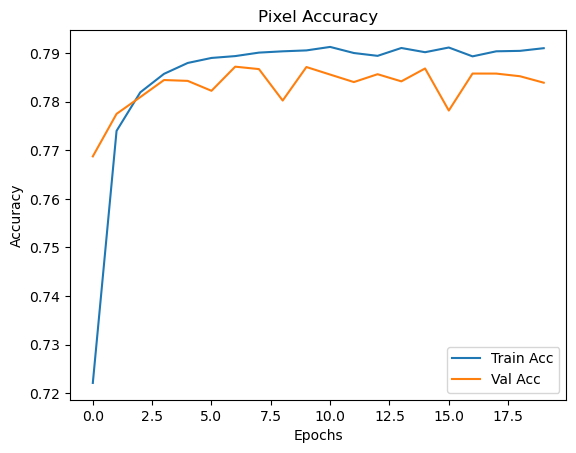

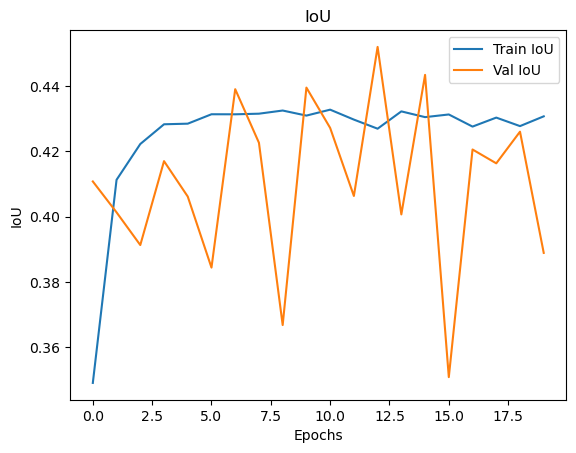

In [20]:
import matplotlib.pyplot as plt
  
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Pixel Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history.history["iou_metric"], label="Train IoU")
plt.plot(history.history["val_iou_metric"], label="Val IoU")
plt.title("IoU")
plt.xlabel("Epochs")
plt.ylabel("IoU")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


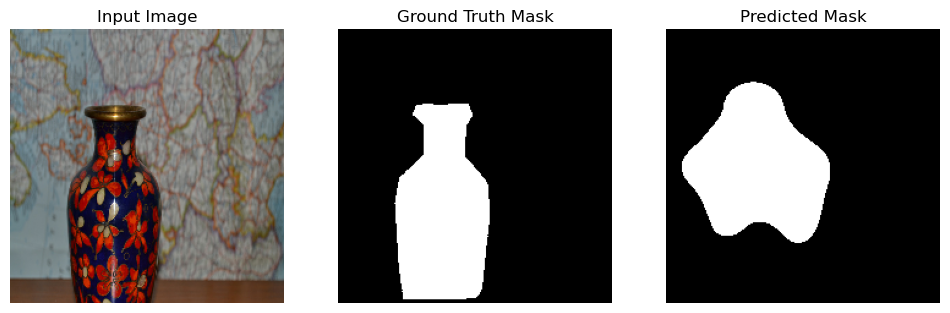

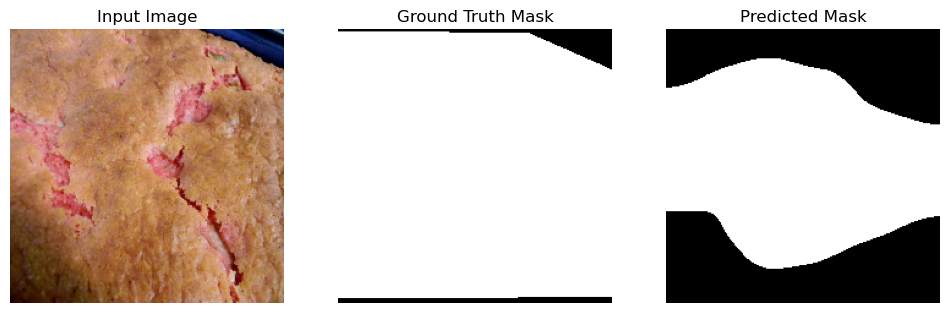

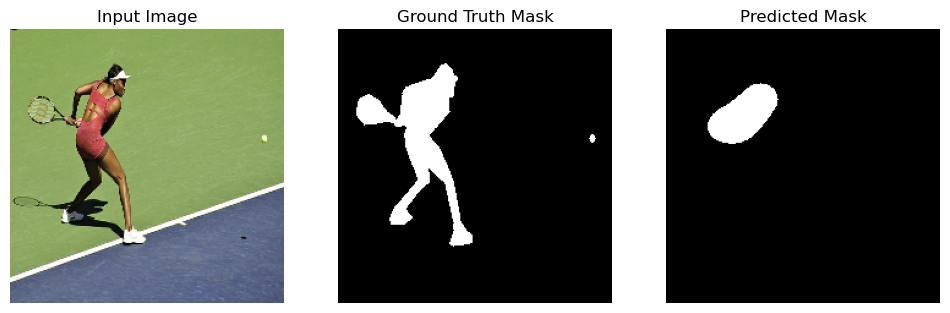

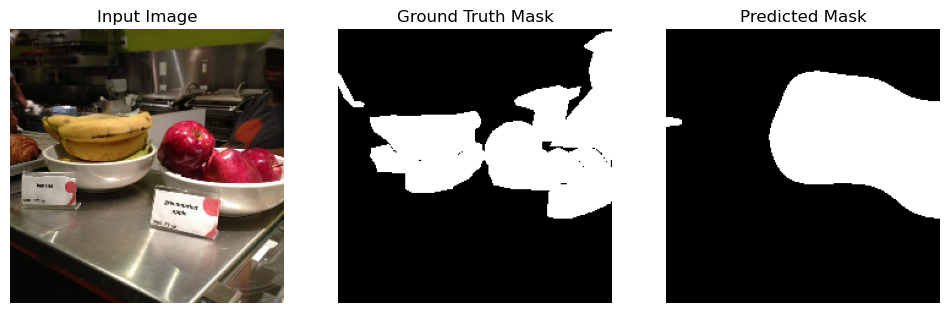

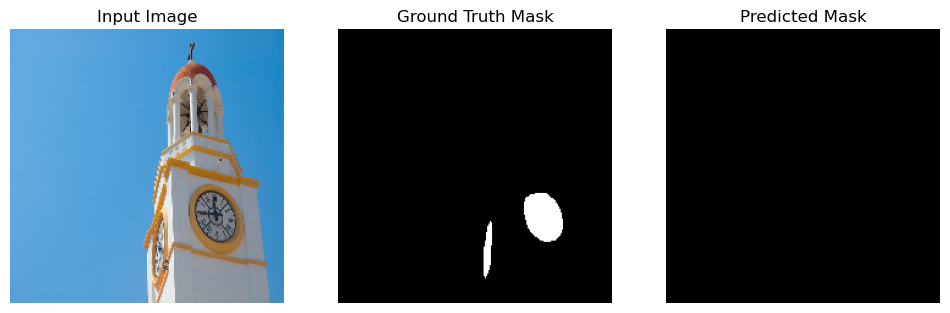

In [21]:
import matplotlib.pyplot as plt

def display_predictions(dataset, model, num_samples=3):
    for images, masks in dataset.take(1):
        preds = model.predict(images)
        preds = (preds > 0.5).astype("float32")  

        for i in range(num_samples):
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.imshow(images[i])
            plt.title("Input Image")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(masks[i].numpy().squeeze(), cmap="gray")
            plt.title("Ground Truth Mask")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(preds[i].squeeze(), cmap="gray")
            plt.title("Predicted Mask")
            plt.axis("off")

            plt.show()

display_predictions(val_dataset, model, num_samples=5)